# Time Series Simulation with Multiple Loads and Generators

This notebook is an extension of the `time_series.ipynb` tutorial, focusing on the simulation of multiple loads and generators using the timeseries and control modules in pandapower. In this advanced tutorial, we will demonstrate how to perform a time series simulation that includes:

* Multiple loads with varying active and reactive power demands.
* Multiple generators with varying power outputs.
* The use of `ConstControl` to dynamically set the active and reactive power values for loads and generators based on a time series data source.

A time series calculation requires the following inputs:
* A pandapower network (`net`).
* The time series data (in a pandas DataFrame, for example).

By the end of this tutorial, you will be able to set up and run a time series simulation on any arbitrary network in pandapower that accurately models the behavior of a power network with multiple loads and generators over time.

First we need some imports. Specific for this example are:
* ConstControl -> "constant" controllers, which change the P and Q values of sgens and loads
* DFData -> The Dataframe Datasource. This Dataframe holds the time series to be calculated
* OutputWriter -> The output writer, which is required to write the outputs to the hard disk
* run_timeseries -> the "main" time series function, which basically calls the controller functions (to update the P, Q of the ConstControllers) and runpp.

In [145]:
import os
import numpy as np
import pandas as pd
import tempfile
import random
import pandapower as pp
from pandapower.timeseries import DFData
from pandapower.timeseries import OutputWriter
from pandapower.timeseries.run_time_series import run_timeseries
from pandapower.control import ConstControl

random.seed(10)

## Function Documentation: `create_data_source`

### Description
The `create_data_source` function generates a time series data source for a given pandapower network. It creates a pandas DataFrame containing the active and reactive power values for loads and generators over a specified number of timesteps. The function also introduces random variations to these values based on a scaling factor.

### Parameters
- `net` (pandapowerNet): The pandapower network object containing the buses, loads, and generators.
- `scale` (float): A scaling factor used to introduce random variations to the power values.
- `n_timesteps` (int, optional): The number of timesteps for which the time series data is generated. Default is 24.

### Returns
- `profiles` (pandas.DataFrame): A DataFrame containing the time series data for active and reactive power values of loads and generators.
- `ds` (DFData): A DataFrame DataSource object that can be used with pandapower controllers.

In [146]:
def create_data_source(net, scale, n_timesteps):
    profiles = pd.DataFrame()

    for each_time_step in range(n_timesteps):
        # this loop is to create the profiles for each time step
        for index, row in net.bus.iterrows():
            # this loop is to create the load profiles for each bus having a load connected
            if row['name'] in net.load['bus'].values:
                p_mw = net.load.loc[net.load['bus'] == row['name'], ['p_mw', 'q_mvar']].values[0][0]
                q_mvar = net.load.loc[net.load['bus'] == row['name'], ['p_mw', 'q_mvar']].values[0][1]
                if p_mw is not None: # if the load has a p_mw value
                    p_mw = p_mw + scale*random.random()*p_mw
                if q_mvar is not None: # if the load has a q_mvar value
                    q_mvar = q_mvar + scale*random.random()*q_mvar
                # add the load values to the profiles dataframe
                profiles.loc[each_time_step, str(row['name']) + '_load_p'] = p_mw
                profiles.loc[each_time_step, str(row['name']) + '_load_q'] = q_mvar
        # this loop is to create the generation profiles for each bus having a generator connected
        for index, row in net.bus.iterrows():
            if row['name'] in net.gen['bus'].values:
                p_mw = net.gen.loc[net.gen['bus'] == row['name'], ['p_mw']].values[0]
                if p_mw is not None:
                    p_mw = p_mw + scale*random.random()*p_mw
                profiles.loc[each_time_step, str(row['name']) + '_gen_p'] = p_mw
            
    ds = DFData(profiles) # create a data source from the profiles dataframe
    return profiles, ds

### `create_controllers`

This function creates constant controllers for loads and generators in a given network using a specified data source.

#### Parameters:
- `net`: The network object containing the loads and generators.
- `ds`: The data source object that provides the profiles for the loads and generators.

#### Functionality:
1. Iterates over each row in the `net.load` DataFrame:
   - Creates a constant controller for the active power (`p_mw`) of the load.
   - Creates a constant controller for the reactive power (`q_mvar`) of the load.
2. Iterates over each row in the `net.gen` DataFrame:
   - Creates a constant controller for the active power (`p_mw`) of the generator.

In [147]:
def create_controllers(net, ds):
    for index, row in net.load.iterrows(): # create a controller for each load    
        ConstControl(net, element='load', variable='p_mw', element_index=[index],
                    data_source=ds, profile_name=[str(row['bus']) + '_load_p'])
        ConstControl(net, element='load', variable='q_mvar', element_index=[index],
                    data_source=ds, profile_name=[str(row['bus']) + '_load_q'])
    
    for index, row in net.gen.iterrows(): # create a controller for each generator
        ConstControl(net, element='gen', variable='p_mw', element_index=[index],
                    data_source=ds, profile_name=[str(row['bus']) + '_gen_p'])

### `create_output_writer`

This function creates an `OutputWriter` object for logging specific variables during a time series simulation.

#### Parameters:
- `net`: The network object containing the elements to be logged.
- `time_steps`: The number of time steps for the simulation.
- `output_dir`: The directory where the output files will be saved.

#### Returns:
- `ow`: An `OutputWriter` object configured to log specified variables.

#### Functionality:
1. Initializes an `OutputWriter` object with the given network, time steps, and output directory.
2. Logs the following variables to be saved during the time series loop:
   - Active power (`p_mw`) of loads (`res_load`).
   - Voltage magnitude (`vm_pu`) of buses (`res_bus`).
   - Loading percentage (`loading_percent`) of lines (`res_line`).
   - Current (`i_ka`) of lines (`res_line`).
   - Active power (`p_mw`) of generators (`res_gen`).
   - Reactive power (`q_mvar`) of generators (`res_gen`).


In [148]:
def create_output_writer(net, time_steps, output_dir):
    ow = OutputWriter(net, time_steps, output_path=output_dir, output_file_type=".xlsx", log_variables=list())
    # these variables are saved to the harddisk after / during the time series loop
    ow.log_variable('res_load', 'p_mw')
    ow.log_variable('res_bus', 'vm_pu')
    ow.log_variable('res_line', 'loading_percent')
    ow.log_variable('res_line', 'i_ka')
    ow.log_variable('res_gen', 'p_mw')
    ow.log_variable('res_gen', 'q_mvar')
    return ow

Now lets execute the code.

In [149]:
output_dir = os.path.join(tempfile.gettempdir(), "time_series_example")
print("Results can be found in your local temp folder: {}".format(output_dir))
if not os.path.exists(output_dir):
    os.mkdir(output_dir)

# load ieee 14 bus system
net = pp.networks.case14()

# run load flow and save results
pp.runpp(net)

n_timesteps = int(24*60/5) # number of timesteps to be calculated (5 minutes resolution for 24 hours)
scale = 0.5 # scaling factor for the load and generation profiles

profiles, ds = create_data_source(net, scale, n_timesteps) # create profiles and data source

# 3. create controllers (to control P values of the load and the sgen)
create_controllers(net, ds)

# time steps to be calculated. Could also be a list with non-consecutive time steps
time_steps = range(0, n_timesteps)

# 4. the output writer with the desired results to be stored to files.
ow = create_output_writer(net, time_steps, output_dir=output_dir)


# 5. the main time series function
run_timeseries(net, time_steps) # the main time series function

Results can be found in your local temp folder: C:\Users\SOHAIL~1\AppData\Local\Temp\time_series_example


c:\Users\SOHAIL KHAN\.conda\envs\pandapowergrid2op\lib\site-packages\pandapower\timeseries\output_writer.py:177: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'range(0, 288)' has dtype incompatible with bool, please explicitly cast to a compatible dtype first.
  self.output["Parameters"].loc[:, "time_step"] = self.time_steps
c:\Users\SOHAIL KHAN\.conda\envs\pandapowergrid2op\lib\site-packages\pandapower\control\run_control.py:50: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  level = controller.level.fillna(0).apply(asarray).values
100%|██████████| 288/288 [00:08<00:00, 35.99it/s]


In [150]:
print(net.res_line.loading_percent) # print the loading percent of the lines

0     1.932633
1     0.912085
2     0.883914
3     0.680838
4     0.507635
5     0.299216
6     0.778052
7     0.121192
8     0.092007
9     0.226920
10    0.061193
11    0.114592
12    0.070521
13    0.025329
14    0.094329
Name: loading_percent, dtype: float64


If everything works you should have the desired results the output_folder, which is the temporary folder of your operating system (see print statement above).

In [151]:
output_dir

'C:\\Users\\SOHAIL~1\\AppData\\Local\\Temp\\time_series_example'

## Plot the result
Let's read the result from the disk and plot it

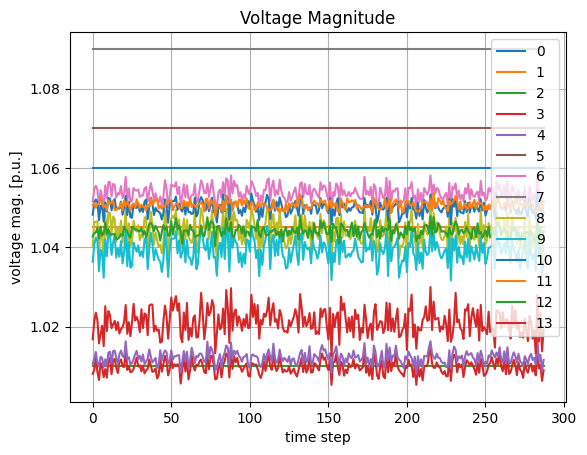

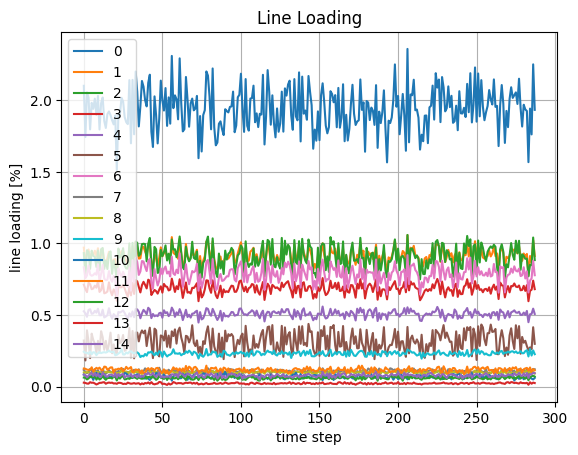

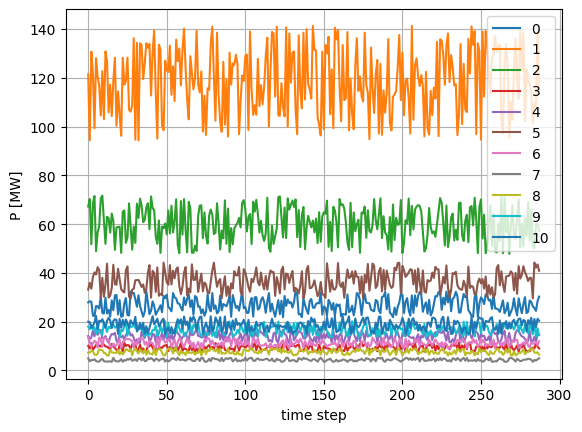

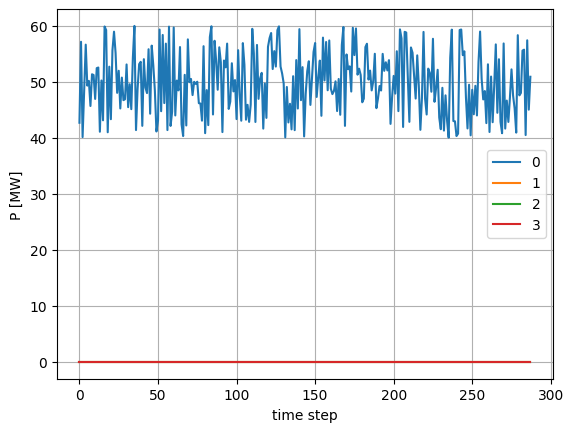

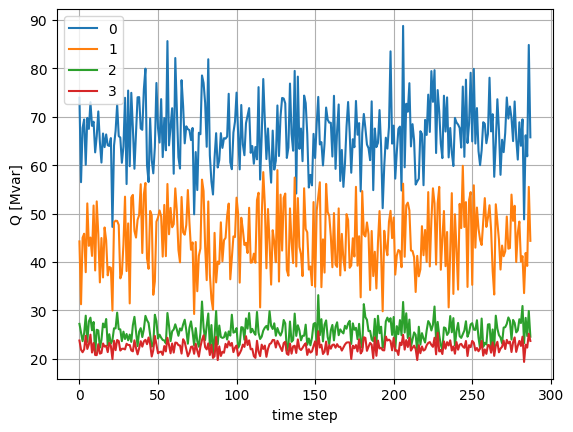

In [152]:
import matplotlib.pyplot as plt
%matplotlib inline  

# voltage results
vm_pu_file = os.path.join(output_dir, "res_bus", "vm_pu.xlsx")
vm_pu = pd.read_excel(vm_pu_file, index_col=0)
vm_pu.plot(label="vm_pu")
plt.xlabel("time step")
plt.ylabel("voltage mag. [p.u.]")
plt.title("Voltage Magnitude")
plt.grid()
plt.show()

# line loading results
ll_file = os.path.join(output_dir, "res_line", "loading_percent.xlsx")
line_loading = pd.read_excel(ll_file, index_col=0)
line_loading.plot(label="line_loading")
plt.xlabel("time step")
plt.ylabel("line loading [%]")
plt.title("Line Loading")
plt.grid()
plt.show()

# load results
load_file = os.path.join(output_dir, "res_load", "p_mw.xlsx")
load = pd.read_excel(load_file, index_col=0)
load.plot(label="load")
plt.xlabel("time step")
plt.ylabel("P [MW]")
plt.grid()
plt.show()

# generation results [p_mw]
gen_file = os.path.join(output_dir, "res_gen", "p_mw.xlsx")
gen = pd.read_excel(gen_file, index_col=0)
gen.plot(label="gen")
plt.xlabel("time step")
plt.ylabel("P [MW]")
plt.grid()
plt.show()

# generation results [q_mvar]
gen_file = os.path.join(output_dir, "res_gen", "q_mvar.xlsx")
gen = pd.read_excel(gen_file, index_col=0)
gen.plot(label="gen")
plt.xlabel("time step")
plt.ylabel("Q [Mvar]")
plt.grid()
plt.show()